In [2]:
import os
import matplotlib.pyplot as plot
# import cv2
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from sklearn.metrics import confusion_matrix as CM
# from random import randint
# from IPython.display import SVG
import matplotlib.gridspec as gridspec
import matplotlib.image as img
import matplotlib.pyplot as plt
import re
from pathlib import Path
import pandas as pd
import seaborn as sn

## PROBLEM 1 - PCA & LDA

### DATA generation

In [ ]:
## funtion for convert the image files into data
def img2df(dir):
    data = pd.DataFrame()
    for each_img in os.listdir(dir):
        i = dir + "/" + each_img
        img2mat = img.imread(i) #image to matrix form
        imgVec = img2mat.reshape(10201,1) #reshape to a vector of size 10201

        #create dataframe and load the vector as column of it. also append the labels(happy(1)/sad(0)) of it at the end
        df = pd.DataFrame(imgVec)
        data = pd.concat([data, df],axis=1, ignore_index=True)
    return data

In [ ]:
## funtion for classify the data into happy(1) or sad(0)
pattern = re.compile(r'(\w*).(\w*)')
def emotion_extract(image):
    ex = pattern.search(image)
    if(ex.group(2) == 'happy'):
        return 1
    return 0

In [ ]:
directory = "/home/Assignment/MLSP/Data/emotion_classification/train"  ##give your file location
data = img2df(directory)
data = data.T

##Standarize the data
scalar = StandardScaler()
scaled_data = pd.DataFrame(scalar.fit_transform(data.to_numpy()))

scaled_data

##add a column for which it's belongs to class of data wither happy(1) or sad(0)


In [ ]:
emotion_list = np.array([])
for each_img in os.listdir(directory):
    if(emotion_extract(each_img) == 1):
        emotion_list = np.append(emotion_list, [1])
    else:
        emotion_list = np.append(emotion_list, [0])

scaled_data["10201"] = emotion_list

# sampled_data = final_data.drop("10201", axis=1)

## Store the data into a csv file

In [ ]:
from pathlib import Path  
filepath = Path('./emotion_data.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
scaled_data.to_csv(filepath, index=False)


# Problem 1.a - **PCA from scratch**

In [ ]:
def PCA_scratch(data, n_components):
    cov_mat = np.cov(data, rowvar=False)    ## find the convariance matrix
    eigenval, eigenvec = np.linalg.eigh(cov_mat)  ## eig() - for square matrix & eigh() - real symm matrix or harmatian matrix

    ## Sort the eigenvectors corresponnding sorted eigenvalues
    sorted_index = np.argsort(eigenval)[::-1]
    sorted_eigenval = eigenval[sorted_index]
    sorted_eigenvec = eigenvec[:,sorted_index]
        
    #Fit transform of original data
    Z = sorted_eigenvec[:,0:n_components]
        
    PC = np.dot(data, Z)
        
    return PC, sorted_eigenval, sorted_eigenvec

In [ ]:
## Read csv file
emo_df = pd.read_csv("emotion_data.csv")

emotion_X = emo_df.iloc[:,:-1]
emotion_Y = emo_df.iloc[:,-1]

# ## Convert it to the numpy data
emo_data = emotion_X.to_numpy()
# type(emotion_Y)

In [ ]:
nof_pc = int(input("Enter the no of principal component : "))
pca, eval, evec = PCA_scratch(emo_data, nof_pc)
 
# pc_df = pd.DataFrame(pca)

# #Concat it with Y to create a complete Dataset
# pc_df = pd.concat([pc_df , pd.DataFrame(emotion_Y)] , axis = 1)
# pc_df.head()

Enter the no of principal component : 2


In [ ]:
eval

array([ 3.07105818e+03,  1.50075986e+03,  9.75157482e+02, ...,
       -1.91649033e-12, -2.55412576e-12, -3.18211417e-12])

In [ ]:
## variance ratio count
explained_variance = eval[0:nof_pc]
total_variance = eval.sum()
explained_variance_ratio = explained_variance / total_variance
cum_var_explained = np.cumsum(explained_variance_ratio)

# cum_var_explained
explained_variance_ratio

array([0.28600189, 0.13976295])

###Plotting the reduced datapoints

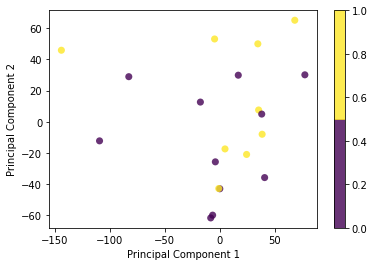

In [ ]:
x1,x2 = pca[:, 0], pca[:, 1]
plt.figure(figsize = (6,4))
plt.scatter(
    x1, x2, c=emotion_Y, s=50, edgecolor="none", alpha=0.8, cmap=plt.cm.get_cmap("viridis", 2)
)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar()
plt.show()

# Problem 1.b - **LDA**

In [3]:
class LDA_scratch:
    def __init__(self, n_components):
        self.n_components = n_components
        self.linear_disc = None

    def fit(self, X, y):
        n_features = X.shape[1]
        class_labels = np.unique(y)

        mean_overall = np.mean(X, axis=0)         # Overall mean of the data
        SW = np.zeros((n_features, n_features))   # Within class scatter matrix
        SB = np.zeros((n_features, n_features))   # Between class scatter

        for c in class_labels:
            X_c = X[y == c]
            mean_c = np.mean(X_c, axis=0)
            # Calculate SW 
            SW += (X_c - mean_c).T.dot((X_c - mean_c))
            
            # Calculate SB
            n_c = X_c.shape[0]
            mean_diff = (mean_c - mean_overall).reshape(n_features, 1)
            SB += n_c * (mean_diff).dot(mean_diff.T)

        # Determine (SW)^-1 * SB
        A = np.linalg.inv(SW).dot(SB)
        # Get eigenvalues and eigenvectors of A
        eigen_val, eigen_vec = np.linalg.eig(A)

        # sort eigenvalues
        eigen_vec = eigen_vec.T
        idxs = np.argsort(abs(eigen_val))[::-1]
        eigen_val = eigen_val[idxs]
        eigen_vec = eigen_vec[idxs]

        # store first n eigenvectors
        self.linear_disc = eigen_vec[0 : self.n_components]

    def transform(self, X):
        return np.dot(X, self.linear_disc.T)


if __name__ == "__main__":
    dt = pd.read_csv("unscaled_data.csv")
    data = dt.iloc[:,:-1].to_numpy()
    classes = dt.iloc[:,-1].to_numpy()

    lda = LDA_scratch(1)
    lda.fit(data, classes)
    transformed_X = lda.transform(data)

    print("Shape of data:", data.shape)
    print("Shape of transformed X:", transformed_X.shape)


Shape of data: (20, 10201)
Shape of transformed X: (20, 1)


In [24]:
x = pd.concat([pd.DataFrame(transformed_X) , pd.DataFrame(classes)] , axis = 1)

In [62]:
x0 = [x.iloc[i,0] for i in range(len(x)) if x.iloc[i,1] == 0]
y0 = [x.iloc[i,1] for i in range(len(x)) if x.iloc[i,1] == 0]

x1 = [x.iloc[i,0] for i in range(len(x)) if x.iloc[i,1] == 1]
y1 = [x.iloc[i,1] for i in range(len(x)) if x.iloc[i,1] == 1]

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


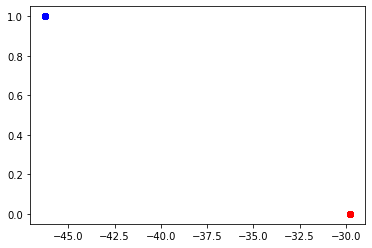

In [64]:
plt.scatter(x0, y0, color='red')
plt.scatter(x1,y1, color='blue')

### Plotting points using histogram

/usr/local/lib/python3.7/dist-packages/numpy/lib/histograms.py:851: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/usr/local/lib/python3.7/dist-packages/matplotlib/transforms.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
/usr/local/lib/python3.7/dist-packages/matplotlib/transforms.py:1969: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = float(x), float(y)


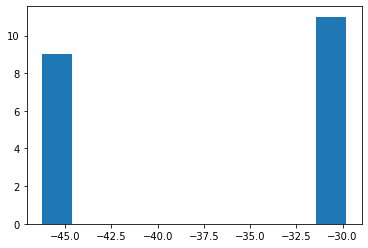

In [77]:
plt.hist(transformed_X)
plt.show()

## Classification

In [65]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(data, classes)

KNeighborsClassifier()

## Test data generation

In [ ]:
test_data = img2df(directory)
test_data = test_data.T
test_data.shape

In [ ]:
emotion_list = np.array([])
for each_img in os.listdir(directory):
    if(emotion_extract(each_img) == 1):
        emotion_list = np.append(emotion_list, [1])
    else:
        emotion_list = np.append(emotion_list, [0])

test_data["10201"] = emotion_list
test_data

In [ ]:
from pathlib import Path  
filepath = Path('./unscaled_test_data.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
test_data.to_csv(filepath, index=False)

### Divide the test into X and y

In [66]:
dt = pd.read_csv("unscaled_test_data.csv")
X_test = dt.iloc[:,:-1].to_numpy()
y_test = dt.iloc[:,-1].to_numpy()
# X

In [67]:
y_predict = model.predict(X_test)

In [70]:
from sklearn import metrics
accuracy = metrics.accuracy_score(y_predict, y_test)
print("Accuracy of test data is : ", accuracy*100, "%")

Accuracy of test data is :  60.0 %


In [75]:
print('*'*10,'Accuracy of Fischer Faces after LDA','*'*10,'\n')
for K in range(1,21):
    neigh = KNeighborsClassifier(n_neighbors = K, weights='uniform', algorithm='auto')
    neigh.fit(data, classes) 
    y_pred = neigh.predict(X_test)
    print ("Accuracy is ", metrics.accuracy_score(y_test,y_pred)*100,"% for K-Value:",K)

********** Accuracy of Fischer Faces after LDA ********** 

Accuracy is  40.0 % for K-Value: 1
Accuracy is  40.0 % for K-Value: 2
Accuracy is  40.0 % for K-Value: 3
Accuracy is  40.0 % for K-Value: 4
Accuracy is  60.0 % for K-Value: 5
Accuracy is  50.0 % for K-Value: 6
Accuracy is  50.0 % for K-Value: 7
Accuracy is  40.0 % for K-Value: 8
Accuracy is  50.0 % for K-Value: 9
Accuracy is  40.0 % for K-Value: 10
Accuracy is  50.0 % for K-Value: 11
Accuracy is  40.0 % for K-Value: 12
Accuracy is  50.0 % for K-Value: 13
Accuracy is  40.0 % for K-Value: 14
Accuracy is  50.0 % for K-Value: 15
Accuracy is  40.0 % for K-Value: 16
Accuracy is  40.0 % for K-Value: 17
Accuracy is  40.0 % for K-Value: 18
Accuracy is  40.0 % for K-Value: 19
Accuracy is  40.0 % for K-Value: 20


In [74]:
print("Since at k = 5, accuracy is higher, best choice of choosing K is 5")

Since at k = 5, accuracy is higher, best choice of choosing K is 5


# Since at k = 5, accuracy is higher, best choice of choosing K is 5